In [1]:
import sys
sys.path.append("..")
from utils.dataset import FerDataset

import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import torchvision

from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
class VGG13(nn.Module):
    
    def __init__(self):
        super(VGG13, self).__init__()
        
        self.convnet = nn.Sequential(
            # 48 x 48 x 1
            nn.Conv2d(1, 64, kernel_size=(3, 3), stride = 1, padding = 1),
            # kernel size F=3, stride S = 1, to retain input size padding must be P = (F - 1)/2
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            # 24 x 24 x 64
            
            # max pool with F=2 and S=2 chooses the max out of a 2x2 square and only keeps that max value.
            # Therefore 75% of the information are left out
            # the max pool layer works on every depth dimension independently, therefore the input depth remains
            # unchanged
            
            #nn.Dropout2d(p=0.25),

            
            nn.Conv2d(64, 128, kernel_size=(3, 3), stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=(3, 3), stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            # 12 x 12 x 128

            #nn.Dropout2d(p=0.25),


            nn.Conv2d(128, 256, kernel_size=(3, 3), stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            # 6 x 6 x 256

            #nn.Dropout2d(p=0.25),


            nn.Conv2d(256, 512, kernel_size=(3, 3), stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            # 3 x 3 x 512
            
            #nn.Dropout2d(p=0.25),
            
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride = 1, padding = 1),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            # 3 x 3 x 512
            
            #nn.Dropout2d(p=0.25)
            
            #nn.AvgPool2d(kernel_size = (3,3), stride=3, padding=3)
            # This layer is not in the pytorch implementation of VGG13 and neither in the paper
            # 3 x 3 x 512
        )
        
        self.fc = nn.Sequential(
            #nn.Linear(512*7*7, 4096), without the AvgPool2d layer
            nn.Linear(512*3*3, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096,10),
        )
        
        
    def forward(self, x):
        x = self.convnet(x)
        #print("x.shape", x.shape)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [7]:
dataset = FerDataset(base_path='../../data',
                     data='ferplus',
                     mode='train',
                     label='ferplus_votes')
dataloader = DataLoader(dataset, batch_size=12, shuffle=True, num_workers=0)
net = VGG13()
log_softmax = nn.LogSoftmax(dim=-1)
criterion = nn.KLDivLoss(size_average=False)
optimizer = torch.optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)

In [8]:
x_batch, y_batch = next(iter(dataloader))
print(x_batch.shape)

torch.Size([12, 1, 48, 48])


In [9]:
losses = []
for i in range(50):
    optimizer.zero_grad()
    logits = net(x_batch)
    log_probs = log_softmax(logits)
    loss = criterion(log_probs, y_batch)
    losses.append(float(loss))
    loss.backward()
    optimizer.step()
    print(i, end='\r')

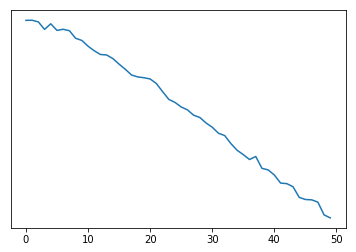

In [10]:
plt.plot(losses)
plt.yscale('log')